# Basic Neural Network From Scratch

$x$: input features

$y$: target labels

$W^l$: weight matrix for layer $l$

$b^l$: bias vector for layer $l$

$z^l$: weighted sum of inputs for layer $l$

$a^l$: activation of layer $l$

$\sigma()$: activation function (e.g., sigmoid, ReLU)

$L$: total number of layers (including input and output layers)

$m$: number of training examples

$J$: cost function (e.g., mean squared error)

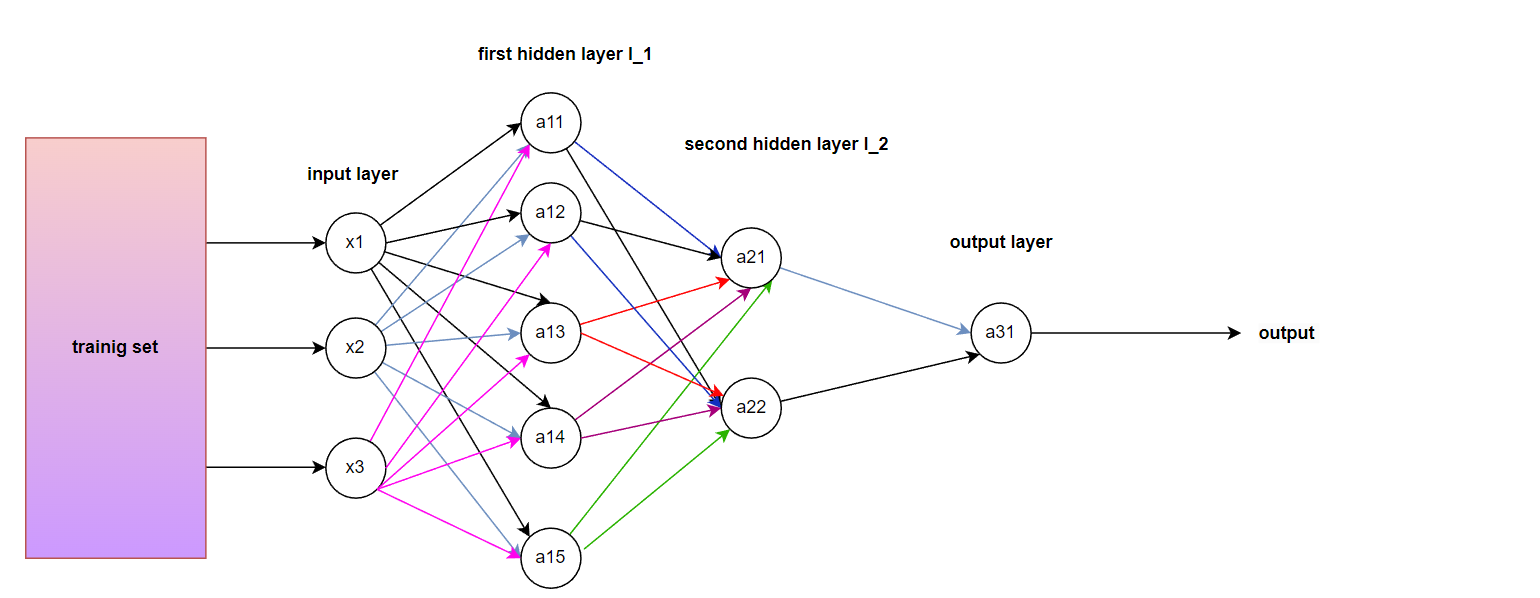

# steps: 
1. Initialize parameters (weights and biases)
2. Forward propagation
3. Compute the cost
4. Backward propagation
5. Update parameters

### Our data set

In [27]:
from sklearn import datasets
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

iris = datasets.load_iris()
X = iris.data
y = iris.target

print("Feature names:", iris.feature_names)
print("Target names:", iris.target_names)
print("Shape of X:", X.shape)
print("Shape of y:", y.shape)

Feature names: ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
Target names: ['setosa' 'versicolor' 'virginica']
Shape of X: (150, 4)
Shape of y: (150,)


## The math inside each step

1. ###### _init_param:
we will initilze the parameters for our neural network 

2. ##### Forward propogation (_forward_prop):
Let $L$ be the total number of layers (including input and output layers) and $a^l$ be the activation of layer $l$. For each hidden layer $l$ from $1$ to $L - 1$, the forward propagation step involves computing the weighted sum of inputs $z^l$ and applying the sigmoid activation function $\sigma()$:

$$z^l = W^l a^{l-1} + b^l$$
$$a^l = \sigma(z^l)$$

For the output layer $L$:

$$z^L = W^L a^{L-1} + b^L$$
$$a^L = \sigma(z^L)$$

where:

- $W^l$ is the weight matrix for layer $l$
- $b^l$ is the bias vector for layer $l$
- $a^0 = x$, the input features
- $\sigma(z) = \frac{1}{1 + e^{-z}}$, the sigmoid activation function

3. ##### compute cost:

we here compute the cross-entropy loss between the predicted output $a^L$ (denoted as `AL` in the code) and the true labels $y$ (denoted as `Y` in the code). Here is the mathematical equation for this function in LaTeX:

$$
\text{cost} = -\frac{1}{m} \sum_{i=1}^m \left[ y^{(i)} \log(a^{L(i)}) + (1 - y^{(i)}) \log(1 - a^{L(i)}) \right]
$$

where:

- $m$ is the number of training examples
- $y^{(i)}$ is the true label for the $i$-th training example
- $a^{L(i)}$ is the predicted output for the $i$-th training example


3. ##### backward propagation: _backward_prop


1. For the output layer $L$:

$$
dZ^L = a^L - y
$$

$$
dW^L = \frac{1}{m} dZ^L (a^{L-1})^T
$$

$$
db^L = \frac{1}{m} \sum_{i=1}^{m} dZ^L_i
$$

2. For each hidden layer $l$ from $L-1$ to $1$:

$$
dZ^l = W^{l+1^T} dZ^{l+1} * g'(z^l)
$$

$$
dW^l = \frac{1}{m} dZ^l (a^{l-1})^T
$$

$$
db^l = \frac{1}{m} \sum_{i=1}^{m} dZ^l_i
$$

where:

- $m$ is the number of training examples
- $g'(z^l)$ is the derivative of the sigmoid activation function with respect to the weighted sum $z^l$, and can be computed as $g'(z^l) = \sigma(z^l)(1 - \sigma(z^l))$
- The `*` operator represents element-wise multiplication


4. ##### update parameters:
updates the weights and biases of the neural network using the gradients computed during backward propagation and the learning rate $\alpha$. For each layer $l$ from $1$ to $L$, the update equations are:

$$
W^l = W^l - \alpha dW^l
$$

$$
b^l = b^l - \alpha db^l
$$

where:

- $\alpha$ is the learning rate
- $dW^l$ and $db^l$ are the gradients of the loss function with respect to the weight matrix $W^l$ and bias vector $b^l$ for layer $l$



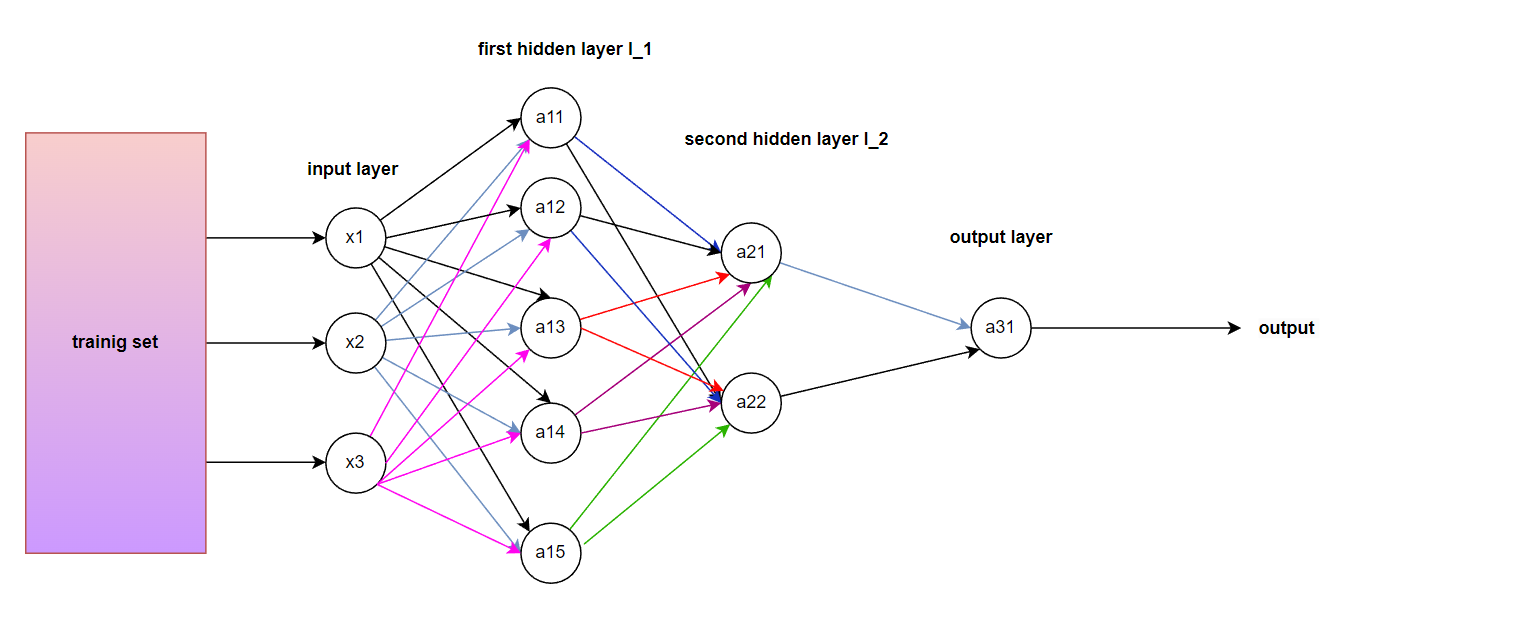

In [56]:
import numpy as np

class HNN():
    # our HNN object will get 3 parameters: 
    # 1) the learning_rate: learning rate (for convergence)
    # 2) layer_dims: is the number of layers wanted
    # 3) num_iterations: number of iteration that our user want 
    def __init__(self, layers_dims, learning_rate=0.01, num_iterations=150):
        
        self.layers_dims = layers_dims
        self.learning_rate = learning_rate
        self.num_iterations = num_iterations
    
    def fit(self, X, y): # the fit method according to the math above
        params = self._init_params(self.layers_dims)
        for _ in range(self.num_iterations):
            A_L, caches = self._forward_prop(X, params)
            cost = self._compute_cost(A_L, y, X.shape[1])
            gradients = self._backward_prop(X, y, A_L, caches, params)
            params = self._update_params(params, gradients, self.learning_rate)

        return params
    
    def _init_params(self, layers_dims): # see the math above
        params = {}
        for l in range(1, len(layers_dims)):
            params['W' + str(l)] = np.random.randn(layers_dims[l], layers_dims[l-1]) * np.sqrt(2 / layers_dims[l-1])
            params['b' + str(l)] = np.zeros((layers_dims[l], 1))

        return params
            
    def _forward_prop(self, X, params): # see the math above
        memory = []
        A_previous = X

        L = len(params) // 2
        for l in range(1, L):
            Z = np.dot(params['W' + str(l)], A_previous) + params['b' + str(l)]
            A = self._sigmoid_function(Z)
            memory.append((A_previous, Z))
            A_previous = A
        
        Z_L = np.dot(params['W' + str(L)], A_previous) + params['b' + str(L)]
        A_L = self._sigmoid_function(Z_L)
        memory.append((A_previous, Z_L))

        return A_L, memory
    
    def _backward_prop(self, X, y, A_L, memory, params): # see the math above
        hidden_L = len(memory)
        m = X.shape[1]
        gradients = {}

        d_Z_L = A_L - y
        d_W_L = (1 / m) * np.dot(d_Z_L, memory[hidden_L - 1][0].T)
        d_b_L = (1 / m) * np.sum(d_Z_L, axis=1, keepdims=True)
        gradients["dW" + str(hidden_L)] = d_W_L
        gradients["db" + str(hidden_L)] = d_b_L

        dZ_previous = d_Z_L

        for l in reversed(range(1, hidden_L)):
            g_der_z = self._sigmoid_der(memory[l - 1][1])
            d_z_l = np.dot(params["W" + str(l + 1)].T, dZ_previous) * g_der_z
            d_w_l = (1 / m) * np.dot(d_z_l, memory[l - 1][0].T)
            d_b_l = (1 / m) * np.sum(d_z_l, axis=1, keepdims=True)
            gradients["dW" + str(l)] = d_w_l
            gradients["db" + str(l)] = d_b_l
            dZ_previous = d_z_l

        return gradients
    
    def _update_params(self, params, gradients, learning_rate): # updating the gradiants with respect to our learning rate
        L = len(params) // 2
        for l in range(1, L + 1):
            params['W' + str(l)] -= learning_rate * gradients['dW' + str(l)]
            params['b' + str(l)] -= learning_rate * gradients['db' + str(l)]

        return params

    def _sigmoid_function(self, z): # sigmoid function
        return 1 / (1 + np.exp(-z))

    def _sigmoid_der(self, z):
        func = self._sigmoid_function(z) # sigmoid function derivitave
        return func * (1 - func)

    def _compute_cost(self, A_L, y, num_observations): # cost function as i showed in the equations above
        m = num_observations
        cost = (-1 / m) * np.sum(y * np.log(A_L) + (1 - y) * np.log(1 - A_L))
        return cost
    
    def predict(self, X, params): # predict 
        A_L, _ = self._forward_prop(X, params)
        predictions = (A_L > 0.5).astype(int)
        return predictions


In [57]:
import numpy as np
from sklearn.datasets import load_iris
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

iris = load_iris()
X = iris.data[iris.target != 2]
y = iris.target[iris.target != 2]

y = y.reshape(-1, 1)
onehot_encoder = OneHotEncoder(sparse=False)
y = onehot_encoder.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [59]:
nn = HNN(layers_dims=[4, 5, 2, 2], learning_rate=0.01, num_iterations=2000)
parameters = nn.fit(X_train.T, y_train.T)

def predict(X, parameters):
    A_L, _ = nn._forward_prop(X, parameters)
    predictions = np.argmax(A_L, axis=0)
    return predictions.reshape(1, -1)

y_pred_train = predict(X_train.T, parameters)
y_pred_test = predict(X_test.T, parameters)

y_train_labels = np.argmax(y_train, axis=1).reshape(1, -1)
y_test_labels = np.argmax(y_test, axis=1).reshape(1, -1)

train_accuracy = accuracy_score(y_train_labels.T, y_pred_train.T)
test_accuracy = accuracy_score(y_test_labels.T, y_pred_test.T)

print("Train accuracy: {:.2f}%".format(train_accuracy * 100))
print("Test accuracy: {:.2f}%".format(test_accuracy * 100))


Train accuracy: 100.00%
Test accuracy: 100.00%
